 # NLP for job listing classification

### Using NLP for job listing classification in the city of New York

In [1]:
# For exploratory data analysis and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# For text preprocessing
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from spacy.lang.en import English
from spacy.lang.es import Spanish

# For BERT pre-trained Language Model
from transformers import BertModel
from transformers import  BertTokenizer, BertForSequenceClassification

import tensorflow as tf
print ("TF version:", tf.__version__)


TF version: 2.10.0


# Loading the data

In [2]:
# Loading the data
df = pd.read_csv("../Data/NYC_Jobs.csv", low_memory=False)

# Data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Job ID                         6362 non-null   int64  
 1   Agency                         6362 non-null   object 
 2   Posting Type                   6362 non-null   object 
 3   # Of Positions                 6362 non-null   int64  
 4   Business Title                 6362 non-null   object 
 5   Civil Service Title            6362 non-null   object 
 6   Title Classification           6362 non-null   object 
 7   Title Code No                  6362 non-null   object 
 8   Level                          6362 non-null   object 
 9   Job Category                   6362 non-null   object 
 10  Full-Time/Part-Time indicator  6118 non-null   object 
 11  Career Level                   6362 non-null   object 
 12  Salary Range From              6362 non-null   f

In [4]:
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Classification,Title Code No,Level,Job Category,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,585084,DEPT OF HEALTH/MENTAL HYGIENE,Internal,1,Deputy EEO Officer (Agency Attorney),AGENCY ATTORNEY,Non-Competitive-5,30087,03,Health Legal Affairs,...,SPECIAL NOTE 1.\tSelected candidate will be re...,To Apply: Please submit resume and cover lette...,NaN,NaN,NaN,New York City residency is generally required ...,07/12/2023,NaN,07/12/2023,08/01/2023
1,577063,DEPT OF HEALTH/MENTAL HYGIENE,External,5,Institutional Aide (per diem),INSTITUTIONAL AIDE,Non-Competitive-5,81803,00,Building Operations & Maintenance,...,SPECIAL NOTE 1.\tSelected candidates will be r...,"TO APPLY, PLEASE SUBMIT RESUME AND COVER LETTE...",NaN,NaN,NaN,New York City residency is generally required ...,03/10/2023,NaN,05/04/2023,08/01/2023
2,540287,DEPT OF ENVIRONMENT PROTECTION,External,1,Machinist,MACHINIST,Competitive-1,92610,00,Building Operations & Maintenance,...,Appointments are subject to OMB approval. For...,Click the âApply Nowâ button,NaN,NaN,NaN,New York City residency is generally required ...,07/16/2022,NaN,07/16/2022,08/01/2023
3,573619,DEPT OF ENVIRONMENT PROTECTION,External,2,Policy Analyst,STRATEGIC INITIATIVE SPECIALIS,Non-Competitive-5,50940,00,"Policy, Research & Analysis",...,Driver License Requirement: At the time of app...,Click on âApply Nowâ and submit a resume a...,35 hours/week,59-17 Junction Blvd Corona Ny,NaN,New York City residency is generally required ...,02/15/2023,NaN,02/15/2023,08/01/2023
4,589409,OFF OF PAYROLL ADMINISTRATION,Internal,2,Help Desk Level 1 Representative,CLERICAL ASSOCIATE,Competitive-1,10251,02,"Technology, Data & Innovation Policy, Research...",...,#O-143 & O-154,Current NYC employees may apply to Job ID: 589...,35 Hours/Day Shift,5 Manhattan West,NaN,New York City residency is generally required ...,06/06/2023,NaN,06/21/2023,08/01/2023


In [5]:
df.describe()

,Job ID,# Of Positions,Salary Range From,Salary Range To,Recruitment Contact
count,6362.000000,6362.000000,6362.000000,6362.000000,0.0
mean,575095.083622,2.417322,61685.868704,85714.222621,NaN
std,21232.953278,8.991682,30822.616545,45143.110546,NaN
min,468473.000000,1.000000,0.000000,15.450000,NaN
25%,568104.500000,1.000000,49033.000000,61438.000000,NaN
50%,582919.000000,1.000000,60000.000000,82504.500000,NaN
75%,590094.000000,1.000000,75504.000000,109409.000000,NaN
max,595861.000000,250.000000,231796.000000,252165.000000,NaN


In [6]:
df.isna().sum()

Job ID                              0
Agency                              0
Posting Type                        0
# Of Positions                      0
Business Title                      0
Civil Service Title                 0
Title Classification                0
Title Code No                       0
Level                               0
Job Category                        0
Full-Time/Part-Time indicator     244
Career Level                        0
Salary Range From                   0
Salary Range To                     0
Salary Frequency                    0
Work Location                       0
Division/Work Unit                  0
Job Description                     0
Minimum Qual Requirements          38
Preferred Skills                 1017
Additional Information           1391
To Apply                            0
Hours/Shift                      3813
Work Location 1                  3199
Recruitment Contact              6362
Residency Requirement               0
Posting Date

In [7]:
duplicates = df.duplicated()
duplicates.sum()

112

In [8]:
df.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Classification', 'Title Code No', 'Level',
       'Job Category', 'Full-Time/Part-Time indicator', 'Career Level',
       'Salary Range From', 'Salary Range To', 'Salary Frequency',
       'Work Location', 'Division/Work Unit', 'Job Description',
       'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'],
      dtype='object')

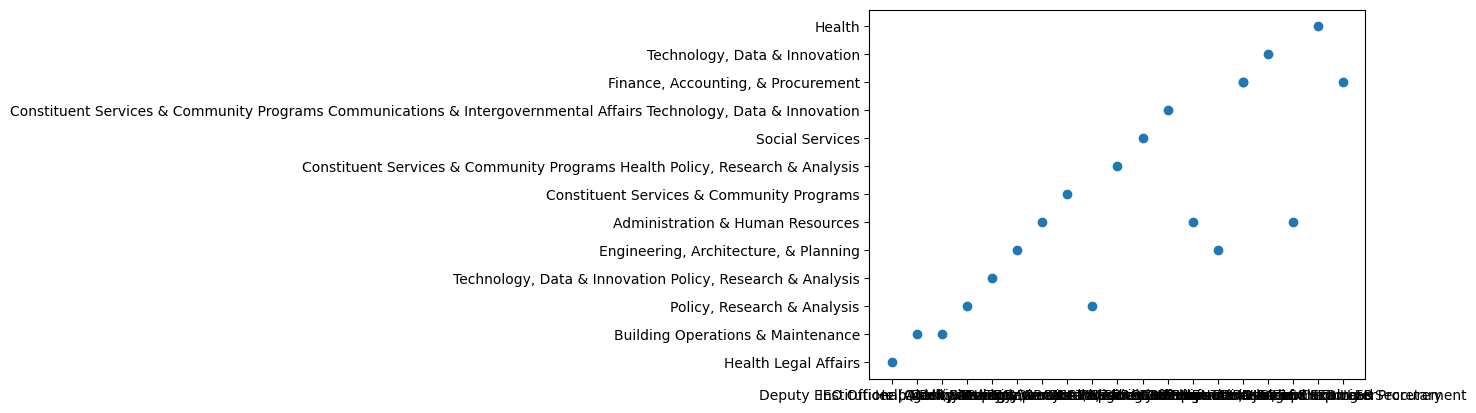

In [9]:
# Data visualization
fig, ax = plt.subplots()
ax.scatter(df["Business Title"][:20], df["Job Category"][:20])

In [10]:
df["Job Category"][:1000]

0                                   Health Legal Affairs
1                      Building Operations & Maintenance
2                      Building Operations & Maintenance
3                            Policy, Research & Analysis
4      Technology, Data & Innovation Policy, Research...
                             ...                        
995                                        Legal Affairs
996                Engineering, Architecture, & Planning
997            Constituent Services & Community Programs
998           Communications & Intergovernmental Affairs
999                     Administration & Human Resources
Name: Job Category, Length: 1000, dtype: object

# Data cleaning

In [11]:
# Removing duplicate rows
cleaned_df = df.drop_duplicates()

In [19]:
duplicates = cleaned_df.duplicated()
duplicates.sum()

0

In [12]:
# Saving cleaned df to a new CSV file
cleaned_df.to_csv('../Data/cleaned_df.csv', index=False)

<Axes: ylabel='Frequency'>

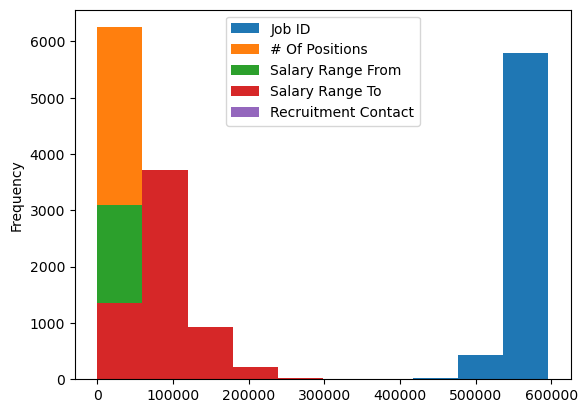

In [13]:
cleaned_df.plot.hist()